In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
requirements_path = '/content/drive/MyDrive/DL_Kamala_Files/requirements.txt'
!pip install -r {requirements_path}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.0/163.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.3/227.3 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3
  Attempting uninstall: soupsieve
    Found existing installation: soupsieve 2.6
    Uninstalling soupsieve-2.6:
      Successfully uninstalled soupsieve-2.6
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
  

In [3]:
model_path = '/content/drive/MyDrive/DL_Kamala_Files/pretrained_Kamala_model/'

In [4]:
import torch
print(torch.cuda.is_available())  # True if a GPU is available
print(torch.cuda.device_count())  # how many GPUs are available

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
1


# Load tokenizer and model

In [5]:
# Load tokenizer and model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import transformers
import logging

# Disable some warnings by setting logging level
transformers.logging.set_verbosity_error()  # Use transformers' logging method

tokenizer = AutoTokenizer.from_pretrained(model_path)
# Set the model to output a single regression value for each input
model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=1,  # This is for regression
    ignore_mismatched_sizes=True  # Ignore the classifier size mismatch
).to(device)


In [6]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119575, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


# Load your training data

In [7]:
# Load your training data
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/DL_Kamala_Files/harris_train_final.csv")

num_samples = len(df)

# Get best batch size

In [8]:
import time

# Function to time how long it takes to process with each batch size
def time_model_with_batch_size(model, tokenizer, dataset, batch_size):
    model.to(device)  # Ensure the model is on the GPU
    start_time = time.time()

    # Tokenize the dataset in batches
    for i in range(0, len(dataset), batch_size):
        batch_texts = dataset[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)

        # Perform a forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs)

    end_time = time.time()
    print(f"Batch size: {batch_size} | Time: {end_time - start_time:.2f} seconds")

# Extract the 'article' column as a list
reviews_list = df['article'].tolist()

# Define different batch sizes to test
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 100 ,200, num_samples]

# Test each batch size
for batch_size in batch_sizes:
    print(f"Testing with batch size: {batch_size}")
    time_model_with_batch_size(model, tokenizer, reviews_list, batch_size)


Testing with batch size: 1
Batch size: 1 | Time: 3.74 seconds
Testing with batch size: 2
Batch size: 2 | Time: 1.30 seconds
Testing with batch size: 4
Batch size: 4 | Time: 0.65 seconds
Testing with batch size: 8
Batch size: 8 | Time: 0.60 seconds
Testing with batch size: 16
Batch size: 16 | Time: 0.62 seconds
Testing with batch size: 32
Batch size: 32 | Time: 0.66 seconds
Testing with batch size: 64
Batch size: 64 | Time: 0.60 seconds
Testing with batch size: 100
Batch size: 100 | Time: 0.61 seconds
Testing with batch size: 200
Batch size: 200 | Time: 0.49 seconds
Testing with batch size: 366
Batch size: 366 | Time: 0.31 seconds


In [9]:
# For Memory purposes use 8
batch_size_best = 8

In [10]:
# Tokenize to check article length in tokens
token_lengths = [len(tokenizer(article)['input_ids']) for article in df['article']]
max(token_lengths)

76

# Train-test split

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into 90% training and 10% validation
train_df, test_df = train_test_split(df, test_size=0.1, random_state=0)

# Get the labels for training and validation sets
train_labels = train_df['score'].tolist()
test_labels = test_df['score'].tolist()

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
print(f"Training labels size: {len(train_labels)}")
print(f"Test labels size: {len(test_labels)}")

Training set size: 329
Test set size: 37
Training labels size: 329
Test labels size: 37


# in this model we use our self made data as validation data

In [12]:
# Load your validation data
import pandas as pd
val_df = pd.read_csv("/content/drive/MyDrive/DL_Kamala_Files/test_harris_final.csv")

# Get the labels for validation set
val_labels = val_df['score'].tolist()

print(f"Validation set size: {len(val_df)}")
print(f"Validation labels size: {len(val_labels)}")

Validation set size: 41
Validation labels size: 41


In [13]:
# Tokenize the training set
inputs_train = tokenizer(
    train_df['article'].tolist(),
    max_length=128,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

# Tokenize the validation set
inputs_val = tokenizer(
    val_df['article'].tolist(),
    max_length=128,
    padding=True,
    truncation=True,
    return_tensors="pt"
)


# Input for model

In [14]:
from torch.utils.data import Dataset, DataLoader

class ArticleDataset(Dataset):
    def __init__(self, inputs_train, train_labels):
        self.inputs = inputs_train
        self.labels = train_labels

    def __len__(self):
        return len(self.labels)  # The length of the dataset

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs['input_ids'][idx],
            'attention_mask': self.inputs['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)  # Ensure labels are tensors
        }

# Create the dataset
train_dataset = ArticleDataset(inputs_train, train_labels)
val_dataset = ArticleDataset(inputs_val, val_labels)

# Create the DataLoader
batch_size = batch_size_best
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffel to prevent overfitting
val_dataloader = DataLoader(val_dataset, batch_size=batch_size) # Don't shuffel


# Apply basic layer freezing since we have a small dataset

In [16]:
# Don't Freeze embeddings
for param in model.distilbert.embeddings.parameters():
    param.requires_grad = True

for layer in model.distilbert.transformer.layer[:4]:  # This will freeze layers 0 to 3
    for param in layer.parameters():
        param.requires_grad = False

# Trainable layers (higher transformer blocks and classifier layers)
for param in model.pre_classifier.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True


#Early stoppage

In [18]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


# Reset model with basic freezing (used if we have to retrain the model)

In [17]:
import random
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to reset the model, set a random seed, and freeze specific layers
def reset_model_and_seed(model_path='/content/drive/MyDrive/DL_Kamala_Files/pretrained_Kamala_model/', seed=0):
    # Set the seed for reproducibility
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reload the pre-trained model from the provided path
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=1,  # This is for regression
        ignore_mismatched_sizes=True  # Ignore the classifier size mismatch
    ).to(device)

    # Freezing layers
    # Don't freeze embeddings
    for param in model.distilbert.embeddings.parameters():
        param.requires_grad = True  # Leave embeddings trainable

    # Freeze the first 4 transformer layers (layers 0 to 3)
    for layer in model.distilbert.transformer.layer[:4]:  # This will freeze layers 0 to 3
        for param in layer.parameters():
            param.requires_grad = False  # Freeze these layers

    # Make sure higher layers (5 and above) are trainable
    for param in model.distilbert.transformer.layer[4:].parameters():
        param.requires_grad = True

    # Ensure the pre-classifier and classifier layers are trainable
    for param in model.pre_classifier.parameters():
        param.requires_grad = True  # Ensure pre-classifier is trainable

    for param in model.classifier.parameters():
        param.requires_grad = True  # Ensure classifier is trainable

    return model


# Get best number of Epochs

Epoch 1, Train Loss: 0.28665419330909137, Validation Loss: 0.11577439890243113
Epoch 2, Train Loss: 0.22025521383399055, Validation Loss: 0.16242070141015574
Epoch 3, Train Loss: 0.2003380143058686, Validation Loss: 0.17231344043587646
Epoch 4, Train Loss: 0.19026256915891454, Validation Loss: 0.17805628300023577
Epoch 5, Train Loss: 0.15927997612882228, Validation Loss: 0.20795086150368056
Epoch 6, Train Loss: 0.14387080898242338, Validation Loss: 0.19958269378791252
Early stopping


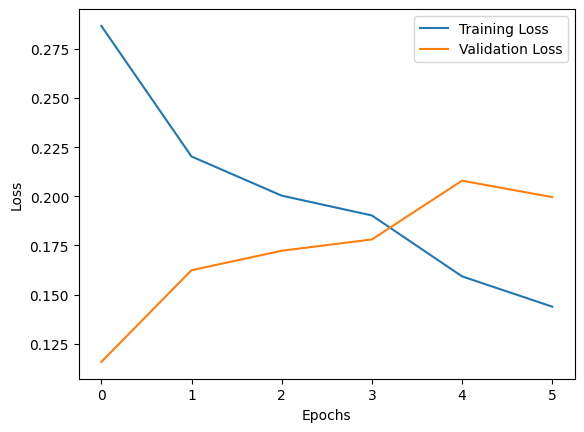

In [19]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import MSELoss

# Function to reset the model, train, and return training/validation loss
def train_model(train_dataloader, val_dataloader, num_epochs=10, patience=5,
                learning_rate=1e-5):

    # Reset the model
    model = reset_model_and_seed()

    # Set optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = MSELoss()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    # Lists to track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)  # Ensure the right shape for regression

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Average training loss
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Return the training and validation losses
    return train_losses, val_losses

# Example call to the train_model function
train_losses, val_losses = train_model(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=50,
    patience=5,
    learning_rate=1e-5,
)

# Plot the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [20]:
# Pick aroud 10 epochs and patience 5 this should be sufficient
best_epochs = 10
patience = 5

# Trying to fix overfitting by increasing dropout


--- Starting Training for Ffn Dropout 0.1 ---

Epoch 1, Train Loss: 0.28665419330909137, Validation Loss: 0.11577439890243113
Epoch 2, Train Loss: 0.22025521383399055, Validation Loss: 0.16242070141015574
Epoch 3, Train Loss: 0.2003380143058686, Validation Loss: 0.17231344043587646
Epoch 4, Train Loss: 0.19026256915891454, Validation Loss: 0.17805628300023577
Epoch 5, Train Loss: 0.15927997612882228, Validation Loss: 0.20795086150368056
Epoch 6, Train Loss: 0.14387080898242338, Validation Loss: 0.19958269378791252

--- Starting Training for Ffn Dropout 0.2 ---

Epoch 1, Train Loss: 0.28665419330909137, Validation Loss: 0.11577439890243113
Epoch 2, Train Loss: 0.22025521383399055, Validation Loss: 0.16242070141015574
Epoch 3, Train Loss: 0.2003380143058686, Validation Loss: 0.17231344043587646
Epoch 4, Train Loss: 0.19026256915891454, Validation Loss: 0.17805628300023577
Epoch 5, Train Loss: 0.15927997612882228, Validation Loss: 0.20795086150368056
Epoch 6, Train Loss: 0.14387080898242

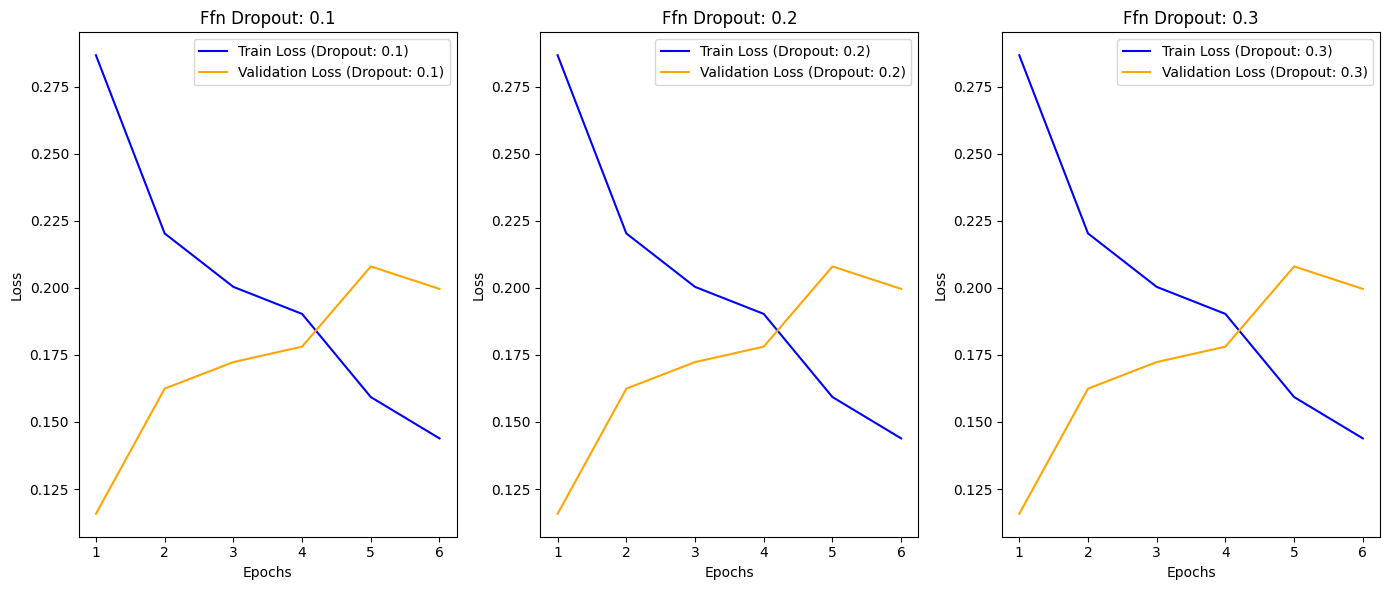


--- Starting Training for Attention Dropout 0.1 ---

Epoch 1, Train Loss: 0.28665419330909137, Validation Loss: 0.11577439890243113
Epoch 2, Train Loss: 0.22025521383399055, Validation Loss: 0.16242070141015574
Epoch 3, Train Loss: 0.2003380143058686, Validation Loss: 0.17231344043587646
Epoch 4, Train Loss: 0.19026256915891454, Validation Loss: 0.17805628300023577
Epoch 5, Train Loss: 0.15927997612882228, Validation Loss: 0.20795086150368056
Epoch 6, Train Loss: 0.14387080898242338, Validation Loss: 0.19958269378791252

--- Starting Training for Attention Dropout 0.2 ---

Epoch 1, Train Loss: 0.28665419330909137, Validation Loss: 0.11577439890243113
Epoch 2, Train Loss: 0.22025521383399055, Validation Loss: 0.16242070141015574
Epoch 3, Train Loss: 0.2003380143058686, Validation Loss: 0.17231344043587646
Epoch 4, Train Loss: 0.19026256915891454, Validation Loss: 0.17805628300023577
Epoch 5, Train Loss: 0.15927997612882228, Validation Loss: 0.20795086150368056
Epoch 6, Train Loss: 0.14

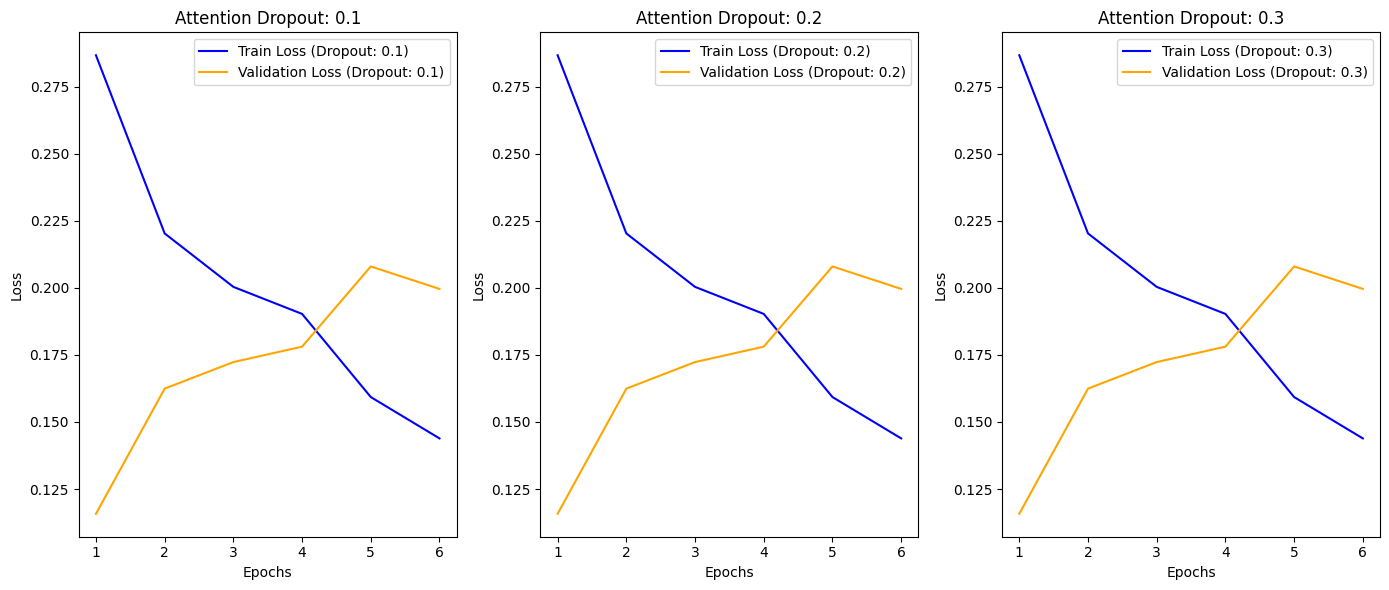


--- Starting Training for Pre_classifier Dropout 0.2 ---

Epoch 1, Train Loss: 0.28665419330909137, Validation Loss: 0.11577439890243113
Epoch 2, Train Loss: 0.22025521383399055, Validation Loss: 0.16242070141015574
Epoch 3, Train Loss: 0.2003380143058686, Validation Loss: 0.17231344043587646
Epoch 4, Train Loss: 0.19026256915891454, Validation Loss: 0.17805628300023577
Epoch 5, Train Loss: 0.15927997612882228, Validation Loss: 0.20795086150368056
Epoch 6, Train Loss: 0.14387080898242338, Validation Loss: 0.19958269378791252

--- Starting Training for Pre_classifier Dropout 0.3 ---

Epoch 1, Train Loss: 0.28665419330909137, Validation Loss: 0.11577439890243113
Epoch 2, Train Loss: 0.22025521383399055, Validation Loss: 0.16242070141015574
Epoch 3, Train Loss: 0.2003380143058686, Validation Loss: 0.17231344043587646
Epoch 4, Train Loss: 0.19026256915891454, Validation Loss: 0.17805628300023577
Epoch 5, Train Loss: 0.15927997612882228, Validation Loss: 0.20795086150368056
Epoch 6, Train 

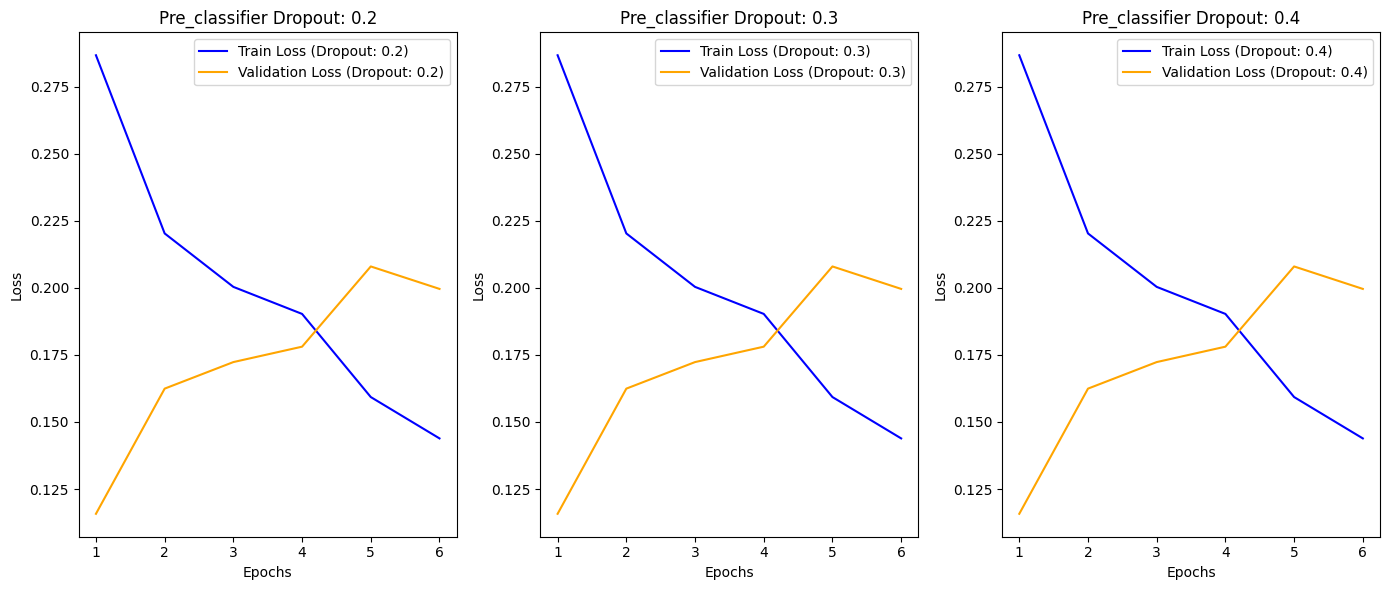

In [21]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import MSELoss

# Function to reset the model, train, and return training/validation loss with adjustable dropout for specific layers
def train_model_with_specific_dropout(train_dataloader, val_dataloader, dropout, layer_type, num_epochs=10, patience=5, learning_rate=1e-5):
    # Reset the model
    model = reset_model_and_seed()

    # Adjust the dropout layers based on the specified layer type
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            if layer_type == 'ffn':  # Target FFN dropout
                if hasattr(module, 'in_features') and module.in_features == 3072:  # Feed-Forward Network
                    module.p = dropout
            elif layer_type == 'attention':  # Target Attention dropout
                if hasattr(module, 'q_lin'):  # Multi-Head Attention
                    module.p = dropout
            elif layer_type == 'pre_classifier':  # Target Pre-Classifier dropout
                if hasattr(module, 'out_features') and module.out_features == 1:  # Pre-classifier
                    module.p = dropout

    # Set optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = MSELoss()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    # Lists to track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        # Print the loss for the current epoch
        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            break

    return train_losses, val_losses


# Function to train and plot for specific layer dropout tuning
def plot_layer_dropout_tuning(layer_type, dropout_values, train_dataloader, val_dataloader):
    train_losses_list = []
    val_losses_list = []

    for dropout in dropout_values:
        print(f"\n--- Starting Training for {layer_type.capitalize()} Dropout {dropout} ---\n")
        train_losses, val_losses = train_model_with_specific_dropout(
            train_dataloader, val_dataloader, dropout=dropout, layer_type=layer_type)
        train_losses_list.append(train_losses)
        val_losses_list.append(val_losses)

    # Plot the results for the current layer type
    epochs = range(1, len(train_losses_list[0]) + 1)
    plt.figure(figsize=(14, 6))

    for i, dropout in enumerate(dropout_values):
        plt.subplot(1, len(dropout_values), i + 1)
        plt.plot(epochs, train_losses_list[i], label=f"Train Loss (Dropout: {dropout})", color='blue')
        plt.plot(epochs, val_losses_list[i], label=f"Validation Loss (Dropout: {dropout})", color='orange')
        plt.title(f"{layer_type.capitalize()} Dropout: {dropout}")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

    plt.tight_layout()
    plt.show()


# Define ranges for each type of dropout
dropout_ffn_values = [0.1, 0.2, 0.3]  # Increasing FFN dropout from 0.1 upwards
dropout_attention_values = [0.1, 0.2, 0.3]  # Increasing Attention dropout from 0.1 upwards
dropout_pre_classifier_values = [0.2, 0.3, 0.4]  # Increasing Pre-Classifier dropout from 0.2 upwards

# 1. Tune and plot Feed-Forward Dropout (FFN)
plot_layer_dropout_tuning(layer_type='ffn', dropout_values=dropout_ffn_values, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

# 2. Tune and plot Attention Dropout
plot_layer_dropout_tuning(layer_type='attention', dropout_values=dropout_attention_values, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

# 3. Tune and plot Pre-Classifier Dropout
plot_layer_dropout_tuning(layer_type='pre_classifier', dropout_values=dropout_pre_classifier_values, train_dataloader=train_dataloader, val_dataloader=val_dataloader)


Has no effect

#Adding a weight decay

Training with weight decay: 0.0
Early stopping at epoch 6
Training with weight decay: 0.01
Early stopping at epoch 6
Training with weight decay: 0.05
Early stopping at epoch 6
Training with weight decay: 0.1
Early stopping at epoch 6


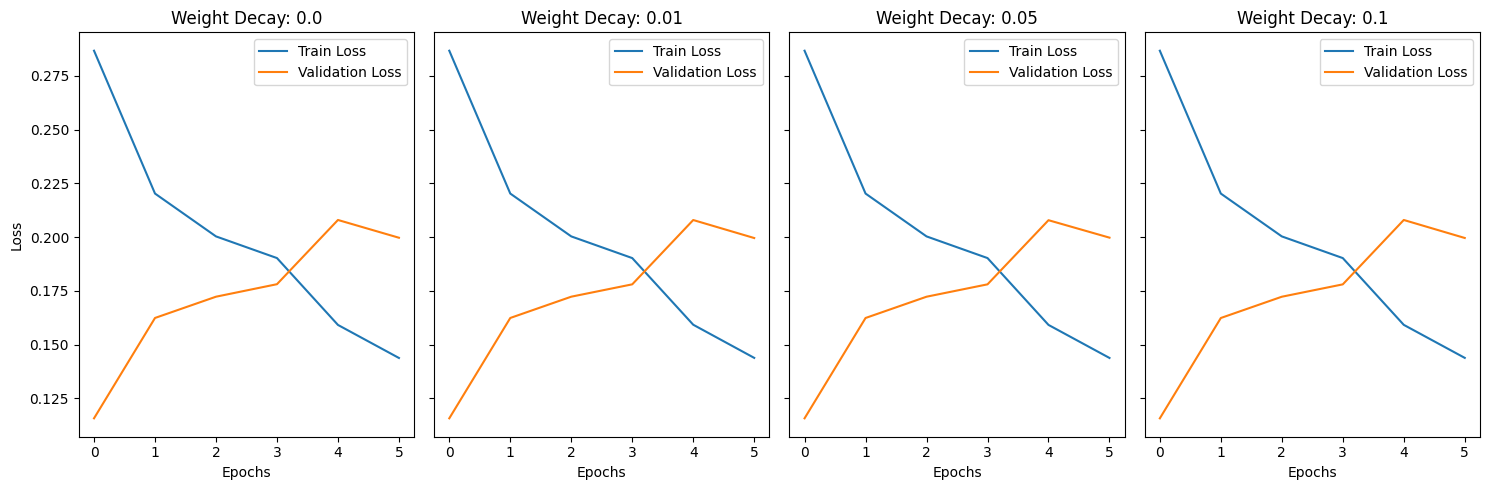

In [22]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import MSELoss

# Define a function to train and track loss with different weight decays
def train_model_with_weight_decay(model, train_dataloader, val_dataloader, num_epochs=10, patience=5, learning_rate=1e-5, weight_decay=0.0):

    # Reset the model at the start of each training loop
    model = reset_model_and_seed()

    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = MSELoss()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return train_losses, val_losses

# List of weight decay values to experiment with
weight_decay_values = [0.0, 0.01, 0.05, 0.1]

# Train and plot for each weight decay value
fig, axes = plt.subplots(1, len(weight_decay_values), figsize=(15, 5), sharey=True)

model = reset_model_and_seed()

for i, weight_decay in enumerate(weight_decay_values):
    print(f"Training with weight decay: {weight_decay}")

    # Reset the model before each weight decay experiment
    model = reset_model_and_seed()

    # Train the model with the current weight decay value
    train_losses, val_losses = train_model_with_weight_decay(
        model, train_dataloader, val_dataloader, num_epochs=10, weight_decay=weight_decay
    )

    # Plot losses
    axes[i].plot(range(len(train_losses)), train_losses, label="Train Loss")
    axes[i].plot(range(len(val_losses)), val_losses, label="Validation Loss")
    axes[i].set_title(f"Weight Decay: {weight_decay}")
    axes[i].set_xlabel("Epochs")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

plt.tight_layout()
plt.show()


 Weight decay also did not improve overfitting

#Combined approach


--- Starting Training with Combined Dropout and Weight Decay ---

Epoch 1, Train Loss: 0.28665419330909137, Validation Loss: 0.11577439890243113
Epoch 2, Train Loss: 0.22025521383399055, Validation Loss: 0.16242070141015574
Epoch 3, Train Loss: 0.2003380143058686, Validation Loss: 0.17231344043587646
Epoch 4, Train Loss: 0.19026256915891454, Validation Loss: 0.17805628300023577
Epoch 5, Train Loss: 0.15927997612882228, Validation Loss: 0.20795086150368056
Epoch 6, Train Loss: 0.14387080898242338, Validation Loss: 0.19958269378791252


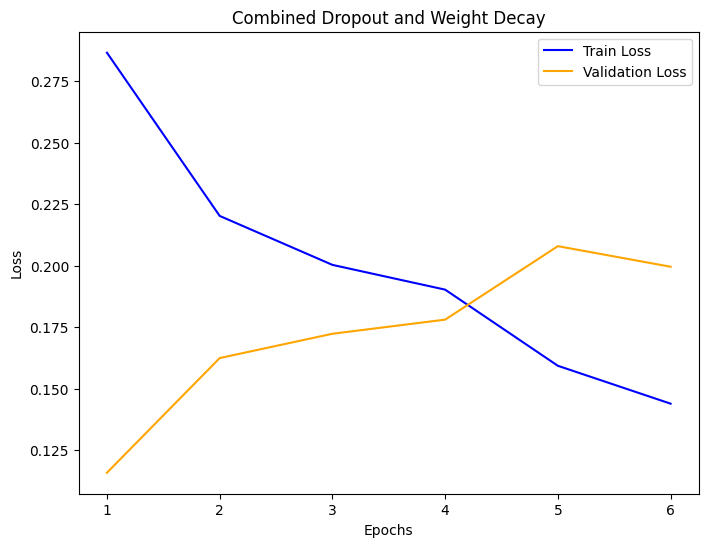

In [24]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import MSELoss

# Function to reset the model, train, and return training/validation loss with adjustable dropout and weight decay
def train_model_with_combined_dropout_and_weight_decay(train_dataloader, val_dataloader, ffn_dropout, attention_dropout, pre_classifier_dropout, weight_decay, num_epochs=10, patience=5, learning_rate=1e-5):
    # Reset the model
    model = reset_model_and_seed()

    # Adjust the dropout layers in the model based on their location
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            if 'ffn' in str(module):  # FFN dropout
                module.p = ffn_dropout
            elif 'attention' in str(module):  # Attention dropout
                module.p = attention_dropout
            elif 'pre_classifier' in str(module):  # Pre-Classifier dropout
                module.p = pre_classifier_dropout

    # Set optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = MSELoss()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    # Lists to track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        # Print the loss for the current epoch
        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            break

    return train_losses, val_losses


# Middle dropout and weight decay values
ffn_dropout = 0.2
attention_dropout = 0.2
pre_classifier_dropout = 0.3
weight_decay = 0.01

# Train and validate with combined dropout and weight decay
print(f"\n--- Starting Training with Combined Dropout and Weight Decay ---\n")
train_losses, val_losses = train_model_with_combined_dropout_and_weight_decay(
    train_dataloader,
    val_dataloader,
    ffn_dropout=ffn_dropout,
    attention_dropout=attention_dropout,
    pre_classifier_dropout=pre_classifier_dropout,
    weight_decay=weight_decay
)

# Plot the results
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label=f"Train Loss", color='blue')
plt.plot(epochs, val_losses, label=f"Validation Loss", color='orange')
plt.title(f"Combined Dropout and Weight Decay")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


This also had no impact implying the issue is elsewhere next try layer freezing

#More Layer Freezing

Epoch 1, Train Loss: 0.28665419330909137, Validation Loss: 0.11577439890243113
Epoch 2, Train Loss: 0.22025521383399055, Validation Loss: 0.16242070141015574
Epoch 3, Train Loss: 0.2003380143058686, Validation Loss: 0.17231344043587646
Epoch 4, Train Loss: 0.19026256915891454, Validation Loss: 0.17805628300023577
Epoch 5, Train Loss: 0.15927997612882228, Validation Loss: 0.20795086150368056
Epoch 6, Train Loss: 0.14387080898242338, Validation Loss: 0.19958269378791252
Early stopping
Epoch 1, Train Loss: 0.288554915360042, Validation Loss: 0.11409091245150194
Epoch 2, Train Loss: 0.2315705574694134, Validation Loss: 0.15442451811395586
Epoch 3, Train Loss: 0.22352541020760933, Validation Loss: 0.15509150464398166
Epoch 4, Train Loss: 0.22275432695945105, Validation Loss: 0.15206516371108592
Epoch 5, Train Loss: 0.20143590601427214, Validation Loss: 0.17536785709671676
Epoch 6, Train Loss: 0.1952486089652493, Validation Loss: 0.16333854182933769
Early stopping
Epoch 1, Train Loss: 0.3286

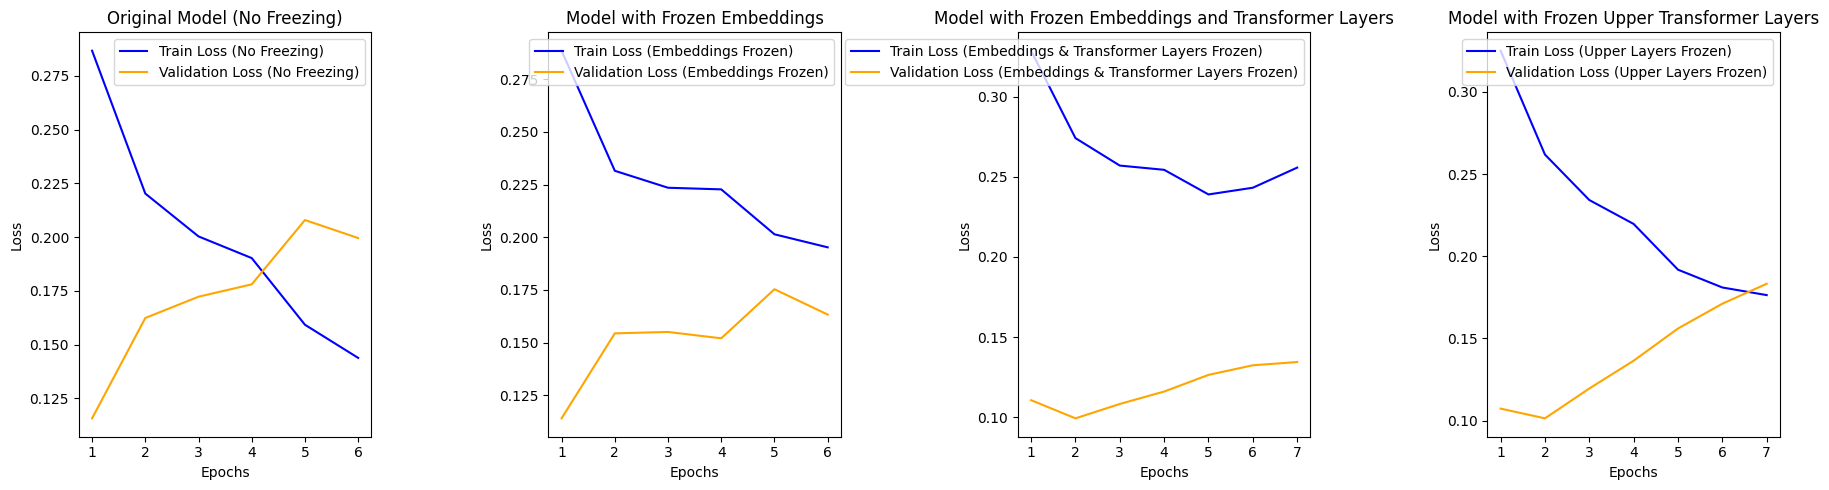

In [30]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import MSELoss

# Function to reset the model, train, and return training/validation loss
def train_model_general(train_dataloader, val_dataloader, num_epochs=10, patience=5, learning_rate=1e-5, freeze_embeddings=False, freeze_upper_layers=False):
    # Reset the model
    model = reset_model_and_seed()

    # Apply freezing logic
    if freeze_embeddings:
        # Freeze embeddings
        for param in model.distilbert.embeddings.parameters():
            param.requires_grad = False  # Freeze embeddings

    if freeze_upper_layers:
        # Freeze the upper transformer layers (layers 4 and above)
        for param in model.distilbert.transformer.layer[4:].parameters():
            param.requires_grad = False

    # Ensure the pre-classifier and classifier layers are trainable
    for param in model.pre_classifier.parameters():
        param.requires_grad = True  # Ensure pre-classifier is trainable

    for param in model.classifier.parameters():
        param.requires_grad = True  # Ensure classifier is trainable

    # Set optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = MSELoss()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    # Lists to track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Average training loss
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Return the training and validation losses
    return train_losses, val_losses

# Call the model training with different freezing levels
# 1. No freezing
train_losses_original, val_losses_original = train_model_general(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    patience=5,
    learning_rate=1e-5,
    freeze_embeddings=False,
    freeze_upper_layers=False
)

# 2. Freeze embeddings only
train_losses_freeze_embeddings, val_losses_freeze_embeddings = train_model_general(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    patience=5,
    learning_rate=1e-5,
    freeze_embeddings=True,
    freeze_upper_layers=False
)

# 3. Freeze embeddings and upper transformer layers
train_losses_freeze_all, val_losses_freeze_all = train_model_general(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    patience=5,
    learning_rate=1e-5,
    freeze_embeddings=True,
    freeze_upper_layers=True
)

# 4. Freeze upper transformer layers only
train_losses_freeze_upper, val_losses_freeze_upper = train_model_general(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    patience=5,
    learning_rate=1e-5,
    freeze_embeddings=False,
    freeze_upper_layers=True
)

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Plot the training and validation losses side by side for comparison
epochs_original = range(1, len(train_losses_original) + 1)
epochs_freeze_embeddings = range(1, len(train_losses_freeze_embeddings) + 1)
epochs_freeze_all = range(1, len(train_losses_freeze_all) + 1)
epochs_freeze_upper = range(1, len(train_losses_freeze_upper) + 1)

plt.figure(figsize=(18, 5))  # Adjust figure size to be wider and less tall

# Plot for the original model (no freezing)
plt.subplot(1, 4, 1)
plt.plot(epochs_original, train_losses_original, label="Train Loss (No Freezing)", color='blue')
plt.plot(epochs_original, val_losses_original, label="Validation Loss (No Freezing)", color='orange')
plt.title("Original Model (No Freezing)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')

# Plot for the model with frozen embeddings
plt.subplot(1, 4, 2)
plt.plot(epochs_freeze_embeddings, train_losses_freeze_embeddings, label="Train Loss (Embeddings Frozen)", color='blue')
plt.plot(epochs_freeze_embeddings, val_losses_freeze_embeddings, label="Validation Loss (Embeddings Frozen)", color='orange')
plt.title("Model with Frozen Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')

# Plot for the model with frozen embeddings and upper transformer layers
plt.subplot(1, 4, 3)
plt.plot(epochs_freeze_all, train_losses_freeze_all, label="Train Loss (Embeddings & Transformer Layers Frozen)", color='blue')  # Adjusted label
plt.plot(epochs_freeze_all, val_losses_freeze_all, label="Validation Loss (Embeddings & Transformer Layers Frozen)", color='orange')  # Adjusted label
plt.title("Model with Frozen Embeddings and Transformer Layers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')

# Plot for the model with only frozen upper layers
plt.subplot(1, 4, 4)
plt.plot(epochs_freeze_upper, train_losses_freeze_upper, label="Train Loss (Upper Layers Frozen)", color='blue')
plt.plot(epochs_freeze_upper, val_losses_freeze_upper, label="Validation Loss (Upper Layers Frozen)", color='orange')
plt.title("Model with Frozen Upper Transformer Layers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()




Pick graph 3 since it overfits the least altough the difference from validation and train loss is significant

# New reset function (resets to correct freeze)

In [31]:
# Function to reset the model, set a random seed, and freeze specific layers
def reset_model_and_seed__frozen(model_path='/content/drive/MyDrive/DL_Kamala_Files/pretrained_Kamala_model/', seed=0):
    # Set the seed for reproducibility
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reload the pre-trained model from the provided path
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=1,  # This is for regression
        ignore_mismatched_sizes=True  # Ignore the classifier size mismatch
    ).to(device)

    # Freezing layers

    for param in model.distilbert.embeddings.parameters():
        param.requires_grad = False  # Freeze embeddings

    # Freeze these layers
    for layer in model.distilbert.transformer.layer[:4]:
        for param in layer.parameters():
            param.requires_grad = False

    for param in model.distilbert.transformer.layer[4:].parameters():
        param.requires_grad = False

    # Ensure the pre-classifier and classifier layers are trainable
    for param in model.pre_classifier.parameters():
        param.requires_grad = True  # Ensure pre-classifier is trainable

    for param in model.classifier.parameters():
        param.requires_grad = True  # Ensure classifier is trainable

    return model

# Attempt a cyclic learning rate to find the best range for learning rate and add gradient clipping to prevent gradient explosion

Epoch 1, Train Loss: 0.3281628865571249, Validation Loss: 0.11218875149885814
Epoch 2, Train Loss: 0.27184510399543105, Validation Loss: 0.10452582780271769
Epoch 3, Train Loss: 0.2538196987782915, Validation Loss: 0.11177581960024933
Epoch 4, Train Loss: 0.2528978806166422, Validation Loss: 0.11978054434681933
Epoch 5, Train Loss: 0.23650200629518145, Validation Loss: 0.13321693628192102
Epoch 6, Train Loss: 0.2413240038301973, Validation Loss: 0.14149740059410001
Epoch 7, Train Loss: 0.25377084297083674, Validation Loss: 0.1431496852261868
Early stopping


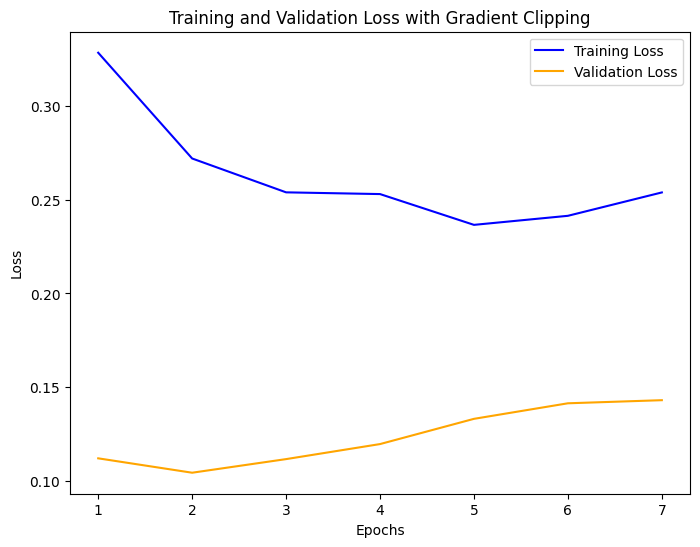

In [32]:
import torch
from torch.optim import AdamW
from torch.nn import MSELoss

# Function to reset the model, train, and return training/validation loss with gradient clipping
def train_model_with_gradient_clipping(train_dataloader, val_dataloader, num_epochs=10, patience=5, learning_rate=1e-5, max_norm=1.0):
    # Reset the model (using your function with frozen layers)
    model = reset_model_and_seed__frozen()

    # Set optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = MSELoss()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    # Lists to track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping (apply to all parameters)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            # Optimization step
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        # Print the loss for the current epoch
        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return train_losses, val_losses

# Train the model with gradient clipping
train_losses, val_losses = train_model_with_gradient_clipping(train_dataloader, val_dataloader, num_epochs=10, learning_rate=1e-5, max_norm=1.0)

# Plot training and validation loss
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label="Training Loss", color='blue')
plt.plot(epochs, val_losses, label="Validation Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss with Gradient Clipping")
plt.legend()
plt.show()


#Try different Norms

Epoch 1, Train Loss: 0.3286618856447084, Validation Loss: 0.11062367167323828
Epoch 2, Train Loss: 0.2741350547543594, Validation Loss: 0.09929939017941554
Epoch 3, Train Loss: 0.2569985365317691, Validation Loss: 0.10825936775654554
Epoch 4, Train Loss: 0.2543564699590206, Validation Loss: 0.1160161814186722
Epoch 5, Train Loss: 0.23899088409684954, Validation Loss: 0.12640713318251073
Epoch 6, Train Loss: 0.24318129351983467, Validation Loss: 0.13240540577680804
Epoch 7, Train Loss: 0.2557310802595956, Validation Loss: 0.1344262596782452
Early stopping

--- Starting Training with Gradient Clipping (max_norm = 0.5) ---

Epoch 1, Train Loss: 0.3281633396233831, Validation Loss: 0.11218901816755533
Epoch 2, Train Loss: 0.27184578372786444, Validation Loss: 0.10452559124678373
Epoch 3, Train Loss: 0.25381795245976674, Validation Loss: 0.11185827820251386
Epoch 4, Train Loss: 0.252868469272341, Validation Loss: 0.1198692757752724
Epoch 5, Train Loss: 0.2364842224688757, Validation Loss: 0

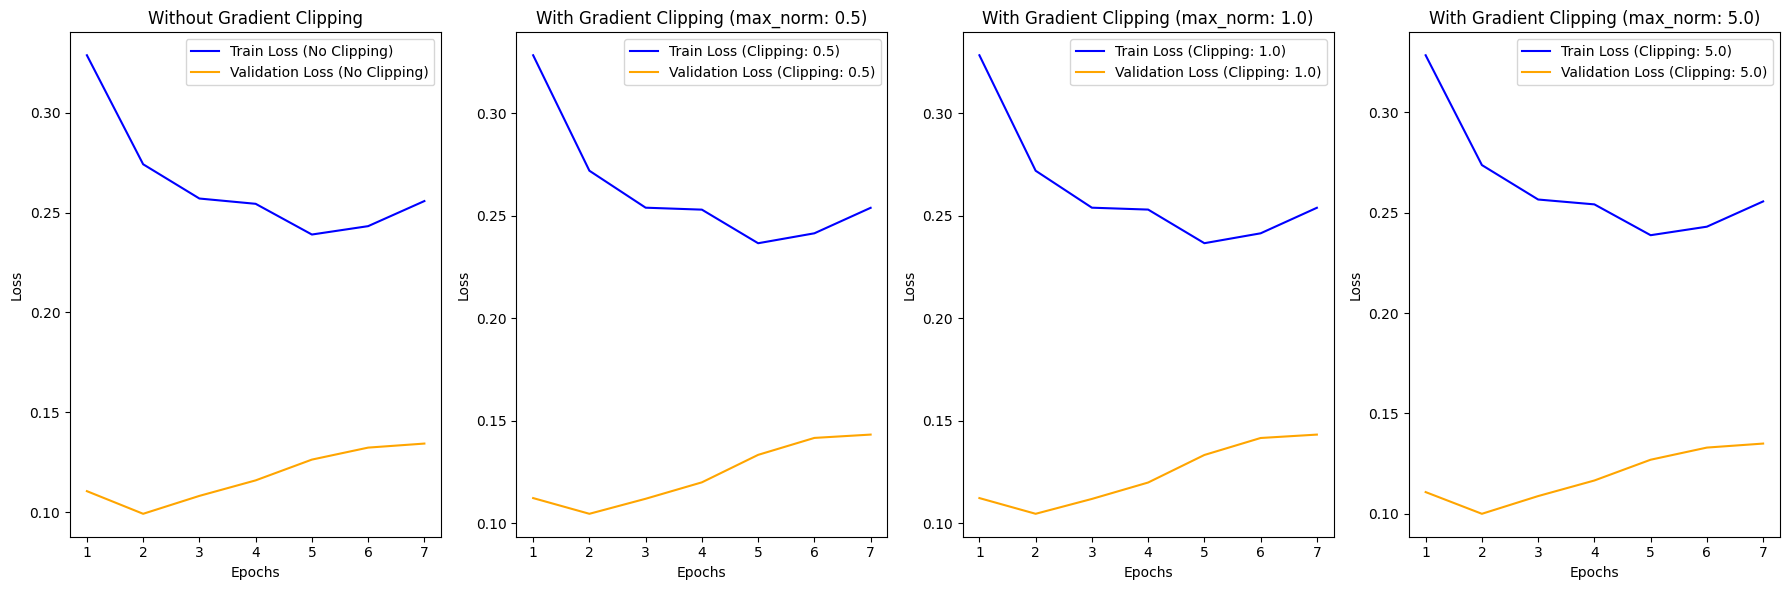

In [33]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import MSELoss
import torch

# Function to train the model without gradient clipping
def train_model_without_clipping(train_dataloader, val_dataloader, num_epochs=10, learning_rate=1e-5, patience=5):
    # Reset the model with frozen layers
    model = reset_model_and_seed__frozen()

    # Set optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = MSELoss()

    # Early stopping initialization
    early_stopping = EarlyStopping(patience=patience)

    # Lists to store loss values
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        # Print epoch results
        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return train_losses, val_losses

# Function to train the model with gradient clipping
def train_model_with_clipping(train_dataloader, val_dataloader, max_norm, num_epochs=10, learning_rate=1e-5, patience=5):
    # Reset the model with frozen layers
    model = reset_model_and_seed__frozen()

    # Set optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = MSELoss()

    # Early stopping initialization
    early_stopping = EarlyStopping(patience=patience)

    # Lists to store loss values
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()

            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        # Print epoch results
        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return train_losses, val_losses

# Train and plot for the model without clipping
train_losses_without, val_losses_without = train_model_without_clipping(train_dataloader, val_dataloader)

# Train and plot for the model with clipping and different max_norm values
max_norm_values = [0.5, 1.0, 5.0]  # Different clipping values
train_losses_with_clipping = []
val_losses_with_clipping = []

for max_norm in max_norm_values:
    print(f"\n--- Starting Training with Gradient Clipping (max_norm = {max_norm}) ---\n")
    train_loss, val_loss = train_model_with_clipping(train_dataloader, val_dataloader, max_norm)
    train_losses_with_clipping.append(train_loss)
    val_losses_with_clipping.append(val_loss)

# Plot the results
epochs = range(1, len(train_losses_without) + 1)
plt.figure(figsize=(18, 6))  # Increase width for 4 plots

# Plot without clipping
plt.subplot(1, 4, 1)  # 1 row, 4 columns, 1st plot
plt.plot(epochs, train_losses_without, label="Train Loss (No Clipping)", color='blue')
plt.plot(epochs, val_losses_without, label="Validation Loss (No Clipping)", color='orange')
plt.title("Without Gradient Clipping")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot with gradient clipping for different values of max_norm
for i, max_norm in enumerate(max_norm_values):
    plt.subplot(1, 4, i + 2)  # 1 row, 4 columns, 2nd, 3rd, and 4th plots
    plt.plot(epochs, train_losses_with_clipping[i], label=f"Train Loss (Clipping: {max_norm})", color='blue')
    plt.plot(epochs, val_losses_with_clipping[i], label=f"Validation Loss (Clipping: {max_norm})", color='orange')
    plt.title(f"With Gradient Clipping (max_norm: {max_norm})")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

plt.tight_layout()
plt.show()


Keep clipping norm 1 and expiriment with different gradients

#Different learning rates

Epoch 1, Train Loss: 0.3569517777789207, Validation Loss: 0.14520927083988985
Epoch 2, Train Loss: 0.3330595918232575, Validation Loss: 0.1369050762926539
Epoch 3, Train Loss: 0.32636607881812824, Validation Loss: 0.12902236357331276
Epoch 4, Train Loss: 0.31481092310111436, Validation Loss: 0.12150618154555559
Epoch 5, Train Loss: 0.3034714455494568, Validation Loss: 0.11487164782981078
Epoch 6, Train Loss: 0.30109260532827603, Validation Loss: 0.11044244685520728
Epoch 7, Train Loss: 0.30913354491903666, Validation Loss: 0.10599191766232252
Epoch 8, Train Loss: 0.2889380550810269, Validation Loss: 0.10250272726019223
Epoch 9, Train Loss: 0.2938222455836478, Validation Loss: 0.10051792363325755
Epoch 10, Train Loss: 0.2742421105504036, Validation Loss: 0.10096589693178733


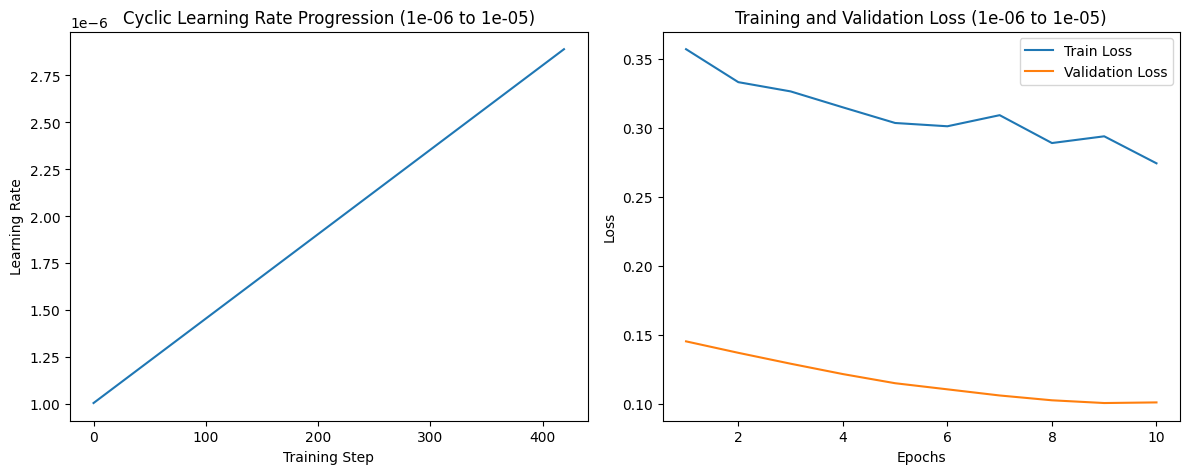

In [34]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import MSELoss
from torch.optim.lr_scheduler import CyclicLR

def train_model_with_clipping_and_cyclic_lr(train_dataloader, val_dataloader, base_lr, max_lr, max_norm=1.0, num_epochs=10, patience=5):
    # Reset the model (your new function to freeze layers)
    model = reset_model_and_seed__frozen()

    # Set optimizer and cyclic learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=base_lr)
    scheduler = CyclicLR(
    optimizer,         # The optimizer to adjust the learning rate for
    base_lr=base_lr,      # Minimum learning rate of the cycle
    max_lr=max_lr,       # Maximum learning rate of the cycle
    mode='triangular2',# Learning rate oscillates with each cycle, reducing the range every cycle# Takes 100 steps to increase from base_lr to max_lr
    cycle_momentum=False  # Disable momentum cycling (since we use AdamW)
)
    # We used triangular2 is sometimes better for preventing overfitting and stabilizing training, especially with small datasets.

    # Set loss function
    criterion = MSELoss()

    # Lists to track losses and learning rates
    train_losses = []
    val_losses = []
    lr_values = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()

            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()
            scheduler.step()  # Adjust learning rate dynamically

            train_loss += loss.item()
            lr_values.append(optimizer.param_groups[0]['lr'])  # Track learning rate

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    return train_losses, val_losses, lr_values


base_lr = 1e-6
max_lr = 1e-5
train_losses, val_losses, lr_values = train_model_with_clipping_and_cyclic_lr(
    train_dataloader, val_dataloader, base_lr=base_lr, max_lr=max_lr, num_epochs=10)

# Plot the cyclic learning rate progression
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lr_values)
plt.title(f'Cyclic Learning Rate Progression ({base_lr} to {max_lr})')
plt.xlabel('Training Step')
plt.ylabel('Learning Rate')

# Plot training and validation loss
epochs = range(1, len(train_losses) + 1)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title(f'Training and Validation Loss ({base_lr} to {max_lr})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


The validation curve looks better with a steady decline implying less overfitting so this gradient is optimal.

# Different step sizes


--- Training with Default Step Size ---

Epoch 1, Train Loss: 0.3569517777789207, Validation Loss: 0.14520927083988985
Epoch 2, Train Loss: 0.3330595918232575, Validation Loss: 0.1369050762926539
Epoch 3, Train Loss: 0.32636607881812824, Validation Loss: 0.12902236357331276
Epoch 4, Train Loss: 0.31481092310111436, Validation Loss: 0.12150618154555559
Epoch 5, Train Loss: 0.3034714455494568, Validation Loss: 0.11487164782981078
Epoch 6, Train Loss: 0.30109260532827603, Validation Loss: 0.11044244685520728
Epoch 7, Train Loss: 0.30913354491903666, Validation Loss: 0.10599191766232252
Epoch 8, Train Loss: 0.2889380550810269, Validation Loss: 0.10250272726019223
Epoch 9, Train Loss: 0.2938222455836478, Validation Loss: 0.10051792363325755
Epoch 10, Train Loss: 0.2742421105504036, Validation Loss: 0.10096589693178733

--- Training with Step Size: 50 ---

Epoch 1, Train Loss: 0.3486125483399346, Validation Loss: 0.12754241221894821
Epoch 2, Train Loss: 0.2941927382323359, Validation Loss: 

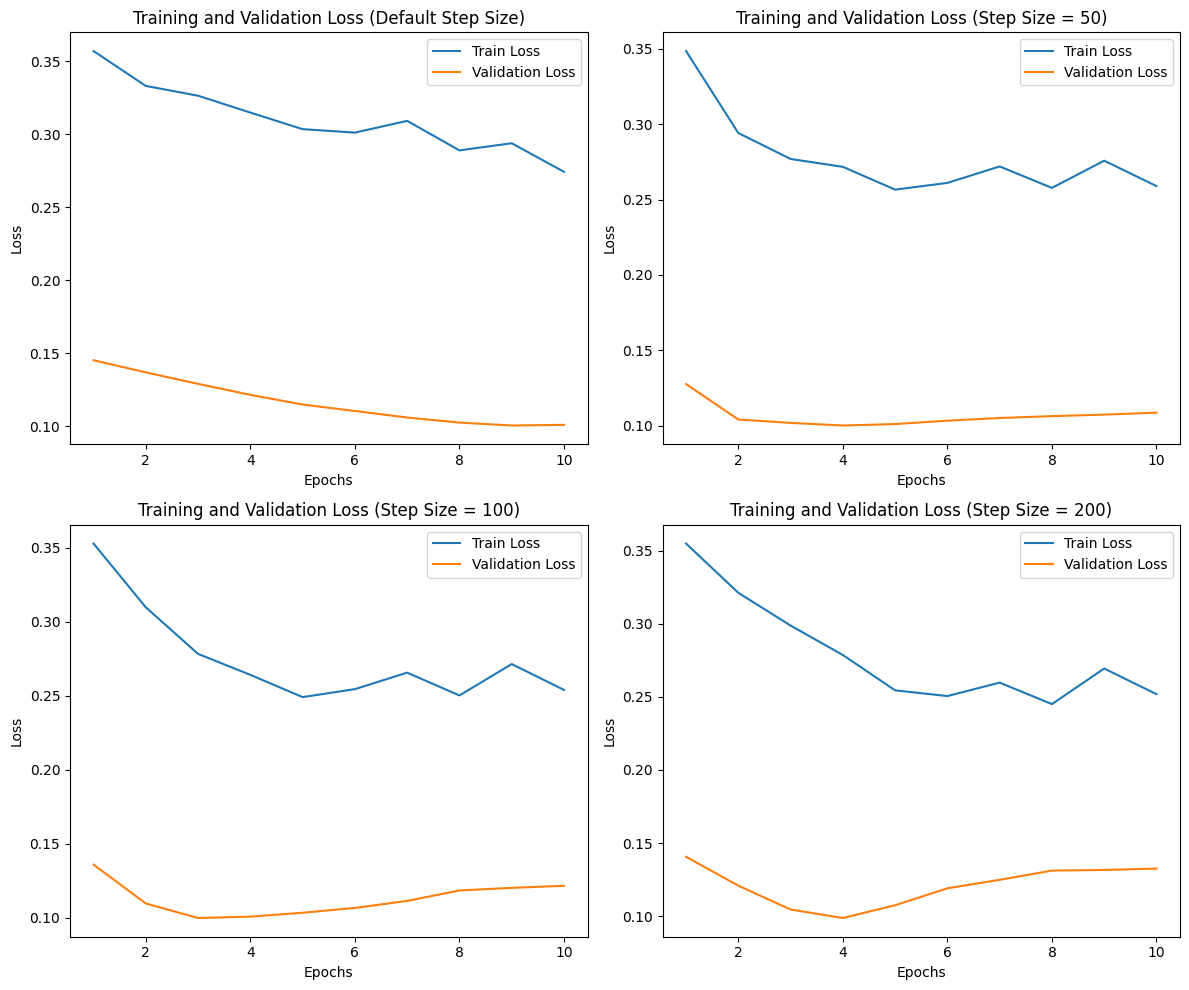

In [35]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import MSELoss
from torch.optim.lr_scheduler import CyclicLR

# Function to train with cyclic learning rates and gradient clipping
def train_model_with_clipping_and_cyclic_lr(train_dataloader, val_dataloader, base_lr, max_lr, step_size_up=None, max_norm=1.0, num_epochs=10, patience=5):
    # Reset the model (your new function to freeze layers)
    model = reset_model_and_seed__frozen()

    # Set optimizer and cyclic learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=base_lr)

    if step_size_up:  # When step_size_up is specified
        scheduler = CyclicLR(
            optimizer,         # The optimizer to adjust the learning rate for
            base_lr=base_lr,   # Minimum learning rate of the cycle
            max_lr=max_lr,     # Maximum learning rate of the cycle
            step_size_up=step_size_up,  # The step size for the learning rate oscillation
            mode='triangular2',  # Learning rate oscillates with each cycle, reducing the range every cycle
            cycle_momentum=False  # Disable momentum cycling (since we use AdamW)
        )
    else:  # When step_size_up is not specified
        scheduler = CyclicLR(
            optimizer,         # The optimizer to adjust the learning rate for
            base_lr=base_lr,   # Minimum learning rate of the cycle
            max_lr=max_lr,     # Maximum learning rate of the cycle
            mode='triangular2',  # Default mode
            cycle_momentum=False  # Disable momentum cycling (since we use AdamW)
        )

    # Set loss function
    criterion = MSELoss()

    # Lists to track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()

            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()
            scheduler.step()  # Adjust learning rate dynamically

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    return train_losses, val_losses


# Test different step sizes for cyclic learning rate, including a default case with no step size
step_sizes = [None, 50, 100, 200]  # 'None' will test the case where step_size_up is not provided
base_lr = 1e-6
max_lr = 1e-5
results = []

for step_size in step_sizes:
    if step_size:
        print(f"\n--- Training with Step Size: {step_size} ---\n")
    else:
        print(f"\n--- Training with Default Step Size ---\n")
    train_losses, val_losses = train_model_with_clipping_and_cyclic_lr(
        train_dataloader, val_dataloader, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size, num_epochs=10)
    results.append((train_losses, val_losses, step_size))

# Plot results for different step sizes
plt.figure(figsize=(12, 10))

for i, (train_losses, val_losses, step_size) in enumerate(results):
    plt.subplot(2, 2, i + 1)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')

    if step_size:
        plt.title(f'Training and Validation Loss (Step Size = {step_size})')
    else:
        plt.title(f'Training and Validation Loss (Default Step Size)')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()


Stick to defualt step size

# Why this is our final model for Kamala

In short, the model minimizes both losses but is primarily concerned with ensuring the validation loss decreases to prevent overfitting.
The cyclic learning rate with appropriate step size can help optimize the balance between training and validation loss by maintaining some flexibility in learning rates throughout the training process.

Epoch 1, Train Loss: 0.3569517777789207, Validation Loss: 0.14520927083988985
Epoch 2, Train Loss: 0.3330595918232575, Validation Loss: 0.1369050762926539
Epoch 3, Train Loss: 0.32636607881812824, Validation Loss: 0.12902236357331276
Epoch 4, Train Loss: 0.31481092310111436, Validation Loss: 0.12150618154555559
Epoch 5, Train Loss: 0.3034714455494568, Validation Loss: 0.11487164782981078
Epoch 6, Train Loss: 0.30109260532827603, Validation Loss: 0.11044244685520728
Epoch 7, Train Loss: 0.30913354491903666, Validation Loss: 0.10599191766232252
Epoch 8, Train Loss: 0.2889380550810269, Validation Loss: 0.10250272726019223
Epoch 9, Train Loss: 0.2938222455836478, Validation Loss: 0.10051792363325755
Epoch 10, Train Loss: 0.2742421105504036, Validation Loss: 0.10096589693178733


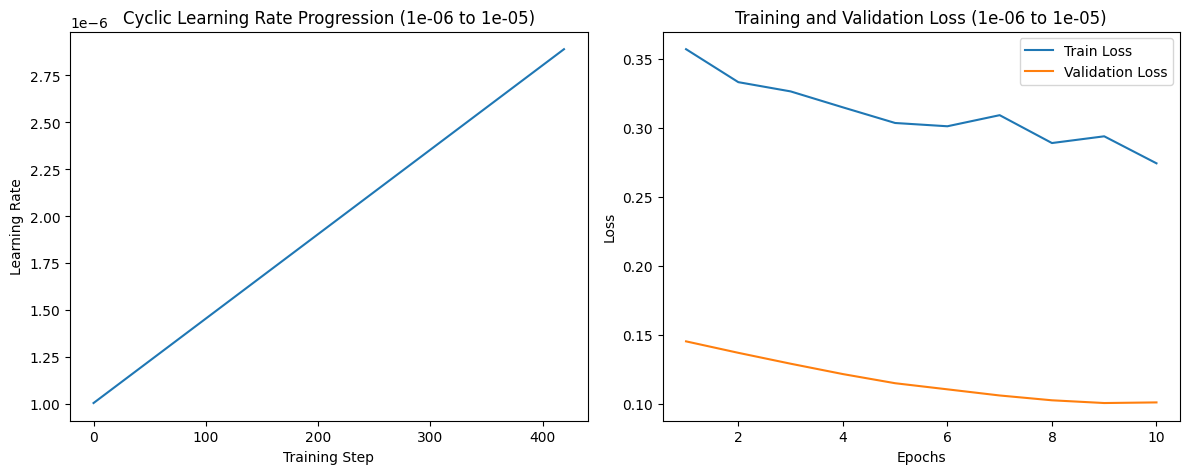

In [47]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import MSELoss
from torch.optim.lr_scheduler import CyclicLR

# Function to train the model with gradient clipping and cyclic learning rate
def train_model_with_clipping_and_cyclic_lr(train_dataloader, val_dataloader, base_lr, max_lr, max_norm=1.0, num_epochs=10, patience=5):
    # Reset the model (ensure layers are frozen based on your function)
    model = reset_model_and_seed__frozen()

    # Set optimizer and cyclic learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=base_lr)
    scheduler = CyclicLR(
        optimizer,         # The optimizer to adjust the learning rate for
        base_lr=base_lr,   # Minimum learning rate of the cycle
        max_lr=max_lr,     # Maximum learning rate of the cycle
        mode='triangular2',  # Learning rate oscillates with each cycle, reducing the range every cycle
        cycle_momentum=False  # Disable momentum cycling (since we use AdamW)
    )
    # Loss function
    criterion = MSELoss()

    # Lists to track losses and learning rates
    train_losses = []
    val_losses = []
    lr_values = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()

            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()
            scheduler.step()  # Adjust learning rate dynamically

            train_loss += loss.item()
            lr_values.append(optimizer.param_groups[0]['lr'])  # Track learning rate

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    # Return model along with the tracked losses and learning rates
    return model, train_losses, val_losses, lr_values


# Base and maximum learning rates
base_lr = 1e-6
max_lr = 1e-5

# Call the function and train the model
final_model, train_losses, val_losses, lr_values = train_model_with_clipping_and_cyclic_lr(
    train_dataloader, val_dataloader, base_lr=base_lr, max_lr=max_lr, num_epochs=10)

# Plot the cyclic learning rate progression
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lr_values)
plt.title(f'Cyclic Learning Rate Progression ({base_lr} to {max_lr})')
plt.xlabel('Training Step')
plt.ylabel('Learning Rate')

# Plot training and validation loss
epochs = range(1, len(train_losses) + 1)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title(f'Training and Validation Loss ({base_lr} to {max_lr})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
# Tokenize the validation set
inputs_test = tokenizer(
    test_df['article'].tolist(),
    max_length=128,
    padding=True,
    truncation=True,
    return_tensors="pt"
)


In [54]:
# Ensure the model is in evaluation mode after training
final_model.eval()

# Predictions for test data
print("Predictions on Test Data (with Articles and Actual Scores):")
print("=" * 100)

with torch.no_grad():
    for i in range(len(test_df)):  # Iterate through test data
        input_ids = inputs_test['input_ids'][i].unsqueeze(0).to(device)
        attention_mask = inputs_test['attention_mask'][i].unsqueeze(0).to(device)
        true_label = torch.tensor(test_labels[i], dtype=torch.float).to(device)

        # Get model prediction on test set
        output_test = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_score_test = output_test.logits.item()

        # Display the article, predicted score, and actual score for test set
        print(f"Test Article {i+1}: {test_df['article'].iloc[i][:100]}...")  # Truncated for readability
        print(f"Prediction: {round(predicted_score_test, 4)}, Actual: {round(true_label.item(), 4)}")
        print("-" * 80)

Predictions on Test Data (with Articles and Actual Scores):
Test Article 1: protrump cnn analyst recoil suggestion could become white dude protrump cnn analyst scott jennings r...
Prediction: -0.1376, Actual: 0.5859
--------------------------------------------------------------------------------
Test Article 2: cnn crew crack van jones say melania onstage next week abortion bomb cnn analyst van jones drew laug...
Prediction: -0.1416, Actual: 0.1027
--------------------------------------------------------------------------------
Test Article 3: ethel cain defends chappell roan refusal endorse ethel cain defends chappell roan people demanding e...
Prediction: -0.1607, Actual: 0.4019
--------------------------------------------------------------------------------
Test Article 4: think faye dunaway communist marxist sunday rally erie pennsylvania rambled knowing difference commu...
Prediction: -0.214, Actual: 0.3818
--------------------------------------------------------------------------

#Conclusion

This model seem to have predicted always negative so implement a sign penalty